# Exercise 14: Trends in IN Snow

In this exercise, we will build on geospatial skills from last week to assemble a dataset of snow observations in Indiana from a global dataset of meteorological observations.  The aim will be to ask whether there are trends in snow in IN.  This exercise will involve automatically downloading data from an external source.

The source dataset is: https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily

In [2]:
""" Import libraries. """
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs
import geopandas as gpd
import pandas as pd
from tqdm.notebook import tqdm # for a progress bar; you'll need to install tqdm and ipywidgets
import scipy
import datetime as dt

In [3]:
""" Load the inventory file. """

# set the inventory file
link = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt"
# "https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/archive/daily-summaries-latest.tar.gz"

# load the inventory file into a pandas dataframe
snow_pd = pd.read_fwf(link, header=None, names=['StationID', 'latitude', 'longitude', 'element', 'start_date', 'end_date'])
snow_pd


,StationID,latitude,longitude,element,start_date,end_date
0,ACW00011604,17.1167,-61.7833,TMAX,1949,1949
1,ACW00011604,17.1167,-61.7833,TMIN,1949,1949
2,ACW00011604,17.1167,-61.7833,PRCP,1949,1949
3,ACW00011604,17.1167,-61.7833,SNOW,1949,1949
4,ACW00011604,17.1167,-61.7833,SNWD,1949,1949
...,...,...,...,...,...,...
742275,ZI000067983,20.2000,32.6160,PRCP,1951,2023
742276,ZI000067983,20.2000,32.6160,TAVG,1962,2023
742277,ZI000067991,22.2170,30.0000,TMAX,1951,1990
742278,ZI000067991,22.2170,30.0000,TMIN,1951,1990


<Axes: >

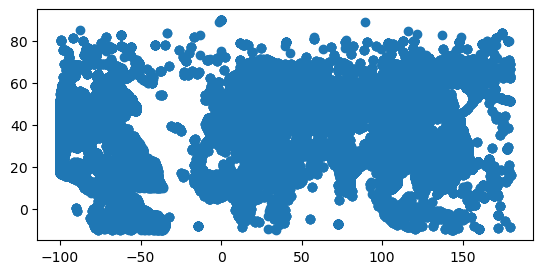

In [4]:
""" Convert the inventory dataframe to a geopandas dataframe. """

#convert
snow_gdf = gpd.GeoDataFrame(snow_pd, 
                           geometry= gpd.points_from_xy(snow_pd['longitude'], snow_pd['latitude']),
                            #could also use gpd.points_from_xy(usgs_pd.longitude, ...
                           crs = "EPSG:4326") #shorthand for lat lon

snow_gdf.plot()

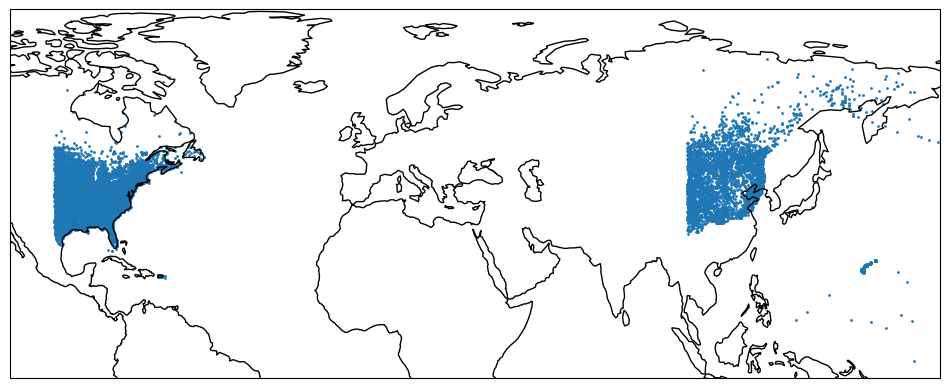

In [5]:
""" Find stations that have at least 50 years of data. """

# find stations that have at least 50 years of data
snow_gdf_50yr = snow_gdf[snow_gdf.end_date - snow_gdf.start_date >= 50]
#snow_gdf_50yr =  snow_gdf_50yr[snow_gdf.end_date - snow_gdf.start_date >= 50]
#snow_gdf_50yr_only = snow_gdf_50yr['atleast50'== True]

# plot the stations that have at least 50 years of SNOW data
snow_gdf_50yr_only = snow_gdf_50yr[snow_gdf_50yr.element == 'SNOW']

projection = cartopy.crs.PlateCarree()

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=projection))

snow_gdf_50yr_only.plot(ax=ax, transform = projection, markersize = 1)

ax.coastlines()

plt.show()


,OBJECTID,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,1,4,9,15,01779782,15,HI,Hawaii,00,G4000,A,1.663425e+10,1.167874e+10,+19.8097670,-155.5061027,2.419034e+06,3.268482e+10,"MULTIPOLYGON (((-17361760.204 2164544.588, -17..."
1,2,3,7,05,00068085,05,AR,Arkansas,00,G4000,A,1.347726e+11,2.959210e+09,+34.8955256,-092.4446262,2.656648e+06,2.053261e+11,"POLYGON ((-10515267.713 4101325.818, -10515269..."
2,3,4,8,35,00897535,35,NM,New Mexico,00,G4000,A,3.141611e+11,7.564385e+08,+34.4346843,-106.1316181,2.900368e+06,4.643927e+11,"POLYGON ((-12138963.727 4106855.170, -12138964..."
3,4,4,8,30,00767982,30,MT,Montana,00,G4000,A,3.769636e+11,3.868565e+09,+47.0511771,-109.6348174,4.607246e+06,8.201836e+11,"POLYGON ((-12727480.235 5886876.586, -12727567..."
4,5,1,2,36,01779796,36,NY,New York,00,G4000,A,1.220579e+11,1.923885e+10,+42.9133974,-075.5962723,3.212630e+06,2.637702e+11,"MULTIPOLYGON (((-8866092.533 5160809.769, -886..."


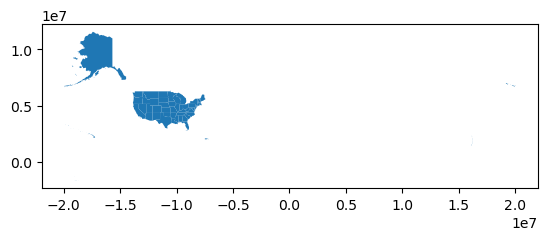

In [6]:
""" Load the state boundary shapefile. """

# set the path to the shapefile
state_shapefile_path = "https://github.com/taobrienlbl/advanced_earth_science_data_analysis/raw/09188e9e6a0cf230f8473c0ae95d2e1b9079df3a/lessons/13_geospatial_intro/data/tl_2012_us_state.zip"

# load the state boundary shapefile
state_boundary_shp = gpd.read_file(state_shapefile_path)

# plot the state boundary shapefile

state_boundary_shp.plot()
state_boundary_shp.head()


<Axes: >

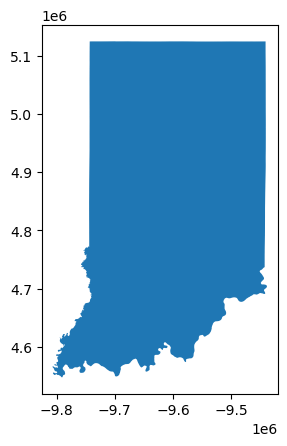

In [7]:
""" Extract the IN row. """
# extract the IN row
IN_boundary = state_boundary_shp[state_boundary_shp.STUSPS == 'IN']

# plot the IN boundary
IN_boundary.plot()

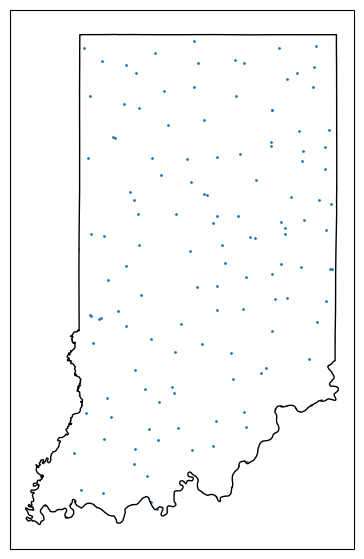

In [8]:
""" Use the IN boundary to clip the snow. """

# convert the in boundary to the same projection as the snow
IN_boundary_proj = IN_boundary.to_crs(snow_gdf_50yr_only.crs)

# clip the snow to the IN boundary
INsnow = gpd.clip(snow_gdf_50yr_only, IN_boundary_proj) #inputs are (dataset to clip, boundary to clip to)

# isolate this to just the SNOW variable
#already did this?
#INsnow_2 = INsnow.element == 'SNOW'

# plot the clipped snow and the state boundary
fig, ax = plt.subplots(figsize=(10,7), subplot_kw=dict(projection=projection))

INsnow.plot(ax=ax, transform = projection, markersize = 1)
IN_boundary_proj.plot(ax=ax, facecolor = 'None', edgecolor = "black")

ax.coastlines()

plt.show()


In [9]:
""" Set the URL template for the GHCN-Daily data. """

# create a function to load the GHCN-Daily data for a station
def load_station_data(station):
    
    #set url for all stations
    url_base = "https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/{station}.csv"
    
    #format URL apparently (??)
    url = url_base.format(station = station)

    # download station data
    station_data = pd.read_csv(url)

    return station_data


# test on the first station
station = (INsnow.iloc[0].StationID) #remember the iloc

station0 = load_station_data(station)
station0.head()


,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,...,MDSF,MDSF_ATTRIBUTES,WT01,WT01_ATTRIBUTES,WT04,WT04_ATTRIBUTES,WT16,WT16_ATTRIBUTES,WT18,WT18_ATTRIBUTES
0,USC00121998,1922-01-08,37.83333,-87.66667,113.1,"CYPRESS DAM 48, IN US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,",,6",NaN,NaN
1,USC00121998,1922-01-13,37.83333,-87.66667,113.1,"CYPRESS DAM 48, IN US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,",,6"
2,USC00121998,1922-01-18,37.83333,-87.66667,113.1,"CYPRESS DAM 48, IN US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,",,6",NaN,NaN
3,USC00121998,1922-01-21,37.83333,-87.66667,113.1,"CYPRESS DAM 48, IN US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,",,6",NaN,NaN,NaN,NaN
4,USC00121998,1922-02-01,37.83333,-87.66667,113.1,"CYPRESS DAM 48, IN US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,",,6",NaN,NaN


In [18]:
#more imports
import warnings
import datetime as dt #wh??

In [11]:
""" Download data for all the stations. """

#take out all station IDs
stationIDs = INsnow.StationID

# lists of stations
station_pd_list = []
bad_station_list = []
warning_station_list = []



# catch warnings #what
warnings.filterwarnings("error")

print("Loading IN GHCN data...") # does this intead?
for stationID in stationIDs:
    try: # what is try?
        try: 
            station_pd = load_station_data(stationID)
            station_pd_list.append(station_pd) # append (??)
        except RuntimeWarning:
                warning_station_list.append(station_pd) #def needed help
    except:
        bad_station_list.append(station) #above my level, man
        continue

# go back to the default warning behavior # what??
warnings.resetwarnings()

Loading IN GHCN data...


In [22]:
""" Combine the data into a single dataframe. """

# combine the data into a single dataframe
in_ghcn_pd = pd.concat(station_pd_list) #this used to be in (): "+ warning_station_list" #took out bc error. # what is this (pd.concat)

# save the data to a CSV file with today's date
in_ghcn_pd.to_csv(f"in_ghcnd_{dt.datetime.today().strftime('%Y-%m-%d')}.csv", index = False) #yeahh #to_csv is a good tool


In [23]:
""" Convert the data to a geopandas dataframe. """

# parse the date column
in_ghcn_pd.DATE = pd.to_datetime(in_ghcn_pd.DATE) #dont need new column

# convert the data to a geopandas dataframe
in_ghcn_gdf = gpd.GeoDataFrame(in_ghcn_pd, 
                           geometry= gpd.points_from_xy(in_ghcn_pd['LONGITUDE'], in_ghcn_pd['LATITUDE']),
                            #could also use gpd.points_from_xy(usgs_pd.longitude, ...
                           crs = "EPSG:4326") #shorthand for lat lon

in_ghcn_gdf.head() #super epic dope it worked?

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,...,WSF5_ATTRIBUTES,WT02,WT02_ATTRIBUTES,WT09,WT09_ATTRIBUTES,GAHT,GAHT_ATTRIBUTES,WT07,WT07_ATTRIBUTES,geometry
0,USC00121998,1922-01-08,37.83333,-87.66667,113.1,"CYPRESS DAM 48, IN US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-87.66667 37.83333)
1,USC00121998,1922-01-13,37.83333,-87.66667,113.1,"CYPRESS DAM 48, IN US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-87.66667 37.83333)
2,USC00121998,1922-01-18,37.83333,-87.66667,113.1,"CYPRESS DAM 48, IN US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-87.66667 37.83333)
3,USC00121998,1922-01-21,37.83333,-87.66667,113.1,"CYPRESS DAM 48, IN US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-87.66667 37.83333)
4,USC00121998,1922-02-01,37.83333,-87.66667,113.1,"CYPRESS DAM 48, IN US",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-87.66667 37.83333)


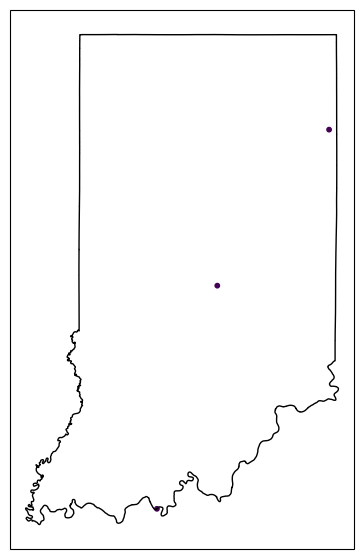

In [44]:
""" Pick a date and plot the snow """
# pick a date
day = in_ghcn_gdf.iloc[23080].DATE
snowday = in_ghcn_gdf[in_ghcn_gdf.DATE == day]

# pick a date
#IN's biggest snowfall was jan 25, 1978
#target_date = dt.datetime(1978, 1, 25)
#nevermind there is nothing here

#ghcn_target = in_ghcn_gdf[in_ghcn_gdf.DATE == target_date]

# plot the snow
fig, ax = plt.subplots(figsize=(10,7), subplot_kw=dict(projection=projection))

snowday.plot(ax=ax, 
            #ghnc_target.plot(ax=ax, 
            transform = projection, 
            column = "SNOW", #if just this, generates points colored by magnitude
            markersize = np.exp(snowday.SNOW)*10,
            )

IN_boundary_proj.plot(ax=ax, 
                    facecolor = 'None', 
                    edgecolor = "black")

ax.coastlines()

plt.show()

## Breakpoint

If you want to spend class time on your final project, here would be a good place to end the exercise.  Otherwise, I encourage you to keep going.

In [15]:
""" Calculate the total snow each year."""
# sum by year

' Calculate the total snow each year.'

In [16]:
""" Calculate the trend in snow. """

# calculate the trend in snow

# get the lat/lon for each station from the inventory

# convert the dataframe to a geodataframe

# rename the columns


' Calculate the trend in snow. '

In [17]:
""" Plot the trend in snow. """


# plot the trends, using the trend magnitude as the color and marker size

# plot the state boundary




' Plot the trend in snow. '